In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

'''
from google.colab import drive
drive.mount('/content/drive')
'''

# Set some parameters
BATCH_SIZE = 5 # the higher the better
IMG_WIDTH = 512 # for faster computing on kaggle
IMG_HEIGHT = 512 # for faster computing on kaggle
IMG_CHANNELS = 3

#TRAIN_PATH = '/content/drive/My Drive/UNet/Cell'
#TEST_PATH = '/content/drive/My Drive/UNet/Cell'

# TRAIN_PATH = './Cell/'
# TEST_PATH = './Cell/'

TRAIN_PATH = './new_data/14'
TEST_PATH = './new_data/14'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

/home/chenzhong/miniconda3/envs/anzhe/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
X_train = np.load('./label-free-viability-assay/X_images.npy')
Y_train = np.load('./label-free-viability-assay/Y_labels.npy')

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'
# os.environ['WORLD_SIZE'] = '20'
# os.environ['RANK'] = '0'
# dist.init_process_group(backend='nccl')

#x, y, x_val, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)
#split dataset to 80% 10% 10%
split_ratio = 0.1
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0]*test_ratio)

X_test = x_val[split_test:]
#test_ids = X_test

x_val = x_val[:split_test]
y_val = y_val[:split_test]

# print(x.shape)
# print(y.shape)

########when label is matched delete this#######################
#x = x[:93]
#x_val = x_val[:93]
################################################################
x_train_tensor = torch.from_numpy(x)
y_train_tensor = torch.from_numpy(y)
# x_train_tensor = torch.tensor(x_train_tensor, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)
x_train_tensor = x_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_train_tensor = y_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
#print(x_train_tensor.shape)
#print(y_train_tensor.shape)
x_val_tensor = torch.from_numpy(x_val)
y_val_tensor = torch.from_numpy(y_val)
# x_val_tensor = torch.tensor(x_val_tensor, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.float32)
x_val_tensor = x_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_val_tensor = y_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
# val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [4]:
def show_mask(mask, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

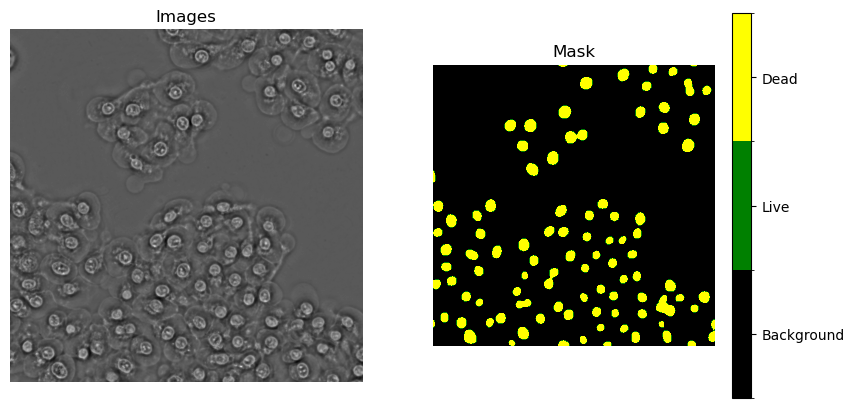

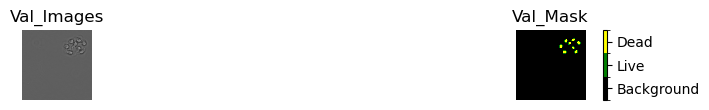

In [5]:

import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[2,:,:,0], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
show_mask(y[2],"Mask")

plt.figure(figsize=(10, 2))
plt.subplot(2, 2, 1)
plt.imshow(x_val[2,:,:,0], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
show_mask(y_val[2],"Val_Mask")
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)


In [6]:
# Define IoU metric
import torch

# def mean_iou(y_pred, y_true, num_classes=3):
#     prec = []
    
#     for class_id in range(num_classes):
#         intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
#         union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
#         # Ensure union is not zero
#         union = torch.where(union == 0, torch.ones_like(union), union)
        
#         iou = intersection.float() / union.float()
#         prec.append(iou.item()) 
        
#     return torch.mean(torch.tensor(prec))

def mean_iou(y_pred, y_true, num_classes=3):
    
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []
    
    for class_id in range(num_classes):
       
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
        
        if union == 0:
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        iou_list.append(iou)

    return torch.mean(torch.tensor(iou_list))




In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = SelfAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = SelfAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = SelfAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = SelfAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = SelfAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = SelfAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        #x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        #x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        #x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        #x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        #x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        #x = self.self_attention6(x)
        output = self.output_conv(x)
        return output

In [8]:
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')


In [9]:
def jaccard_loss(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    jaccard_loss = 1.0 - (intersection + 1) / (union + 1) 
    return jaccard_loss

In [8]:
import torch.backends.cudnn as cudnn

c_in = 3  # input channel 3 for RGB
c_out = 3  # output channel
if torch.cuda.device_count() > 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('checkpoint_unet.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
cudnn.benchmark = True
model = torch.nn.DataParallel(model)

class ThreeChannelLogitsLoss(nn.Module):
    def __init__(self):
        super(ThreeChannelLogitsLoss, self).__init__()

    def forward(self, output, target):
        loss = 0
        for i in range(c_out):
            loss += nn.BCEWithLogitsLoss()(output[:, i, :, :], target[:, i, :, :])
        return loss / c_out

#criterion = ThreeChannelLogitsLoss()
#criterion = nn.L1Loss()    
criterion = nn.CrossEntropyLoss()
#criterion = jaccard_loss
#criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True)
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


/home/chenzhong/miniconda3/envs/anzhe/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


NameError: name 'EarlyStopping' is not defined

In [11]:
# #print unet model summary

# from torchsummary import summary

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# #print(model)
# #print(f"Total Trainable Parameters: {count_parameters(model)}")
# summary(model, (3, 128, 128), device= 'cpu')


In [69]:

# Training loop
num_epochs = 100
model.to(device1)
best_loss = 1.0
best_iou = 0.0
log_file = open("training_log_unet_cell13.txt", "w")
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for i,(inputs, labels) in enumerate(tqdm(train_loader)):
        gpu = torch.cuda.get_device_properties(device1)
        #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
        #print(torch.cuda.memory_allocated(device1))
        #print(torch.cuda.max_memory_allocated(device1))
        if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
            model = model.to(device2)
            device1, device2 = device2, device1
            print('changed gpu')
            #inputs, labels = inputs.to(device1), labels.to(device1)
            model = model.to(device1)
            
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        #print(inputs.shape)
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        iou = mean_iou(outputs, labels)
        labels = labels.long()
        # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()

        if i % 50 == 0 and i != 0:
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
            if i % 100 == 0:
                print(f'Saving model...')
                torch.save(model.state_dict(), 'checkpoint.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)

    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}\n")
    log_file.write(f'Best loss: {best_loss}, Best IoU: {best_iou}\n\n')
    log_file.flush()

    if early_stopping(avg_loss, model):
        print('Early stopping triggered')
        break
    
torch.save(model.state_dict(), 'model.pth')
print(f'Best loss is {best_loss}, best iou is {best_iou}')


100%|██████████| 44/44 [01:24<00:00,  1.92s/it]


Epoch [1/100] Loss: 0.0006200630182733717 IoU: 0.9777739061550661
Saving model...


100%|██████████| 44/44 [01:17<00:00,  1.77s/it]


Epoch [2/100] Loss: 0.00018881187076079766 IoU: 0.9934024445035241
Saving model...


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [3/100] Loss: 0.00010763666473807957 IoU: 0.9963487413796511
Saving model...


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [4/100] Loss: 0.00012200191758893197 IoU: 0.9958719936284152
EarlyStopping counter: 1 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [5/100] Loss: 0.00011070938275927553 IoU: 0.996127887205644
EarlyStopping counter: 2 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [6/100] Loss: 0.00011116014936553917 IoU: 0.9967223703861237
EarlyStopping counter: 3 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [7/100] Loss: 0.00011757208961750042 IoU: 0.9969145601445978
EarlyStopping counter: 4 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.79s/it]


Epoch [8/100] Loss: 0.00010184256527943283 IoU: 0.9969469661062415
Saving model...


100%|██████████| 44/44 [01:18<00:00,  1.79s/it]


Epoch [9/100] Loss: 0.0001107513880924671 IoU: 0.996582945639437
EarlyStopping counter: 1 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [10/100] Loss: 0.00012577725051828153 IoU: 0.9961258498105136
EarlyStopping counter: 2 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [11/100] Loss: 0.00010485339891436689 IoU: 0.9969697079875253
EarlyStopping counter: 3 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [12/100] Loss: 8.64852059252867e-05 IoU: 0.9974587613886053
Saving model...


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [13/100] Loss: 9.786597270662737e-05 IoU: 0.9975266321138903
EarlyStopping counter: 1 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [14/100] Loss: 6.678006271117324e-05 IoU: 0.9981012764302167
Saving model...


100%|██████████| 44/44 [01:18<00:00,  1.79s/it]


Epoch [15/100] Loss: 9.668654882427126e-05 IoU: 0.9970725625753403
EarlyStopping counter: 1 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.79s/it]


Epoch [16/100] Loss: 9.00676164250895e-05 IoU: 0.9968321553685449
EarlyStopping counter: 2 out of 5


100%|██████████| 44/44 [01:19<00:00,  1.80s/it]


Epoch [17/100] Loss: 9.384966196276682e-05 IoU: 0.9971173676577482
EarlyStopping counter: 3 out of 5


100%|██████████| 44/44 [01:18<00:00,  1.78s/it]


Epoch [18/100] Loss: 9.733003980727517e-05 IoU: 0.9968612153421749
EarlyStopping counter: 4 out of 5


100%|██████████| 44/44 [01:19<00:00,  1.80s/it]


Epoch [19/100] Loss: 0.00012120135381172241 IoU: 0.9962299479679628
EarlyStopping counter: 5 out of 5
Early stopping triggered
Best loss is 6.678006271117324e-05, best iou is 0.9981012764302167


In [12]:
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_val_loader_predictions(model, data_loader, device, class_colors):
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs = inputs.permute(0, 3, 1, 2).to(device)
#             labels = labels.squeeze(1).to(device)

#             print(f'Inputs shape: {inputs.shape}')
#             print(f'Labels shape: {labels.shape}')
#             print(f'Labels unique values: {np.unique(labels.cpu().numpy())}')

#             outputs = model(inputs)
#             print(f'Model outputs before argmax: {outputs.shape}, min: {outputs.min().item()}, max: {outputs.max().item()}')

#             predicted = torch.argmax(outputs, dim=1).cpu().numpy()
#             true_labels = labels.cpu().numpy()

#             print(f'Model predicted after argmax: {np.unique(predicted)}')
#             print(f'True labels unique values: {np.unique(true_labels)}')

#             for i in range(len(predicted)):
#                 segmented_image = predicted[i]
#                 true_label = true_labels[i]
#                 height, width = segmented_image.shape

#                 color_image_pred = np.zeros((height, width, 3), dtype=np.uint8)
#                 for cls, color in class_colors.items():
#                     mask = segmented_image == cls
#                     color_image_pred[mask] = color

#                 color_image_label = np.zeros((height, width, 3), dtype=np.uint8)
#                 for cls, color in class_colors.items():
#                     mask = true_label == cls
#                     if mask.shape == (height, width):
#                         color_image_label[mask] = color

#                 plt.figure(figsize=(15, 5))

#                 plt.subplot(1, 2, 1)
#                 plt.imshow(color_image_pred)
#                 plt.title("Predicted Output")
#                 plt.axis("off")

#                 plt.subplot(1, 2, 2)
#                 plt.imshow(color_image_label)
#                 plt.title("Ground Truth")
#                 plt.axis("off")

#                 plt.tight_layout()
#                 plt.show()
#                 return

# class_colors = {
#     0: [0, 0, 0],
#     1: [0, 255, 0],
#     2: [255, 255, 0],
# }

# model.to(device1)
# visualize_val_loader_predictions(model, val_loader, device1, class_colors)



In [9]:
model = model.to(device1)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        # print(inputs.shape)
        # print(labels.shape)
        labels = labels.unsqueeze(-1)
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        labels = labels.squeeze(1)
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
preds_val = outputs

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")


100%|██████████| 9/9 [00:25<00:00,  2.88s/it]

Validation Loss: 1.0699149171511333, Validation IoU: 0.31725125511487323


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

model = model.to(device1)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        # Add channel dimension to labels if needed
        labels = labels.unsqueeze(-1)
        
        # Permute inputs and labels for model compatibility
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        
        # Get model outputs and calculate IoU
        outputs = model(inputs)
        labels = labels.squeeze(1)  # Remove the channel dimension for evaluation
        
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        
        # Calculate loss
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
        # Convert model outputs to predicted labels
        preds = torch.argmax(outputs, dim=1)  # Get the predicted class for each pixel
        
        # Append to the lists for metric calculation
        all_preds.append(preds.cpu().numpy().flatten())
        all_labels.append(labels.cpu().numpy().flatten())

# Flatten the lists to create 1D arrays for metric calculation
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

# Print metrics
print(f"Validation Loss: {avg_val_loss}")
print(f"Validation IoU: {avg_val_iou}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


In [ ]:
model = model.to(device1)
model.eval()
# with torch.no_grad():
#     for inputs in tqdm(val_loader):
#         inputs = inputs[0].permute(0, 3, 1, 2).to(device2)
#         outputs = model(inputs)
        #print(outputs.shape)
#torch.save(model.state_dict(),'cell_segment.pth')
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
#model=model.to(device1)
preds_val=[]
preds_test=[]

# X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
# val_X = x_val_tensor.permute(0,3,1,2)
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    # preds_val = model(val_X[:int(val_X.shape[0]*0.06)].to(device2))
    # preds_test = model(X_test[:int(X_test.shape[0]*0.06)].to(device2))
    # preds_val = model(val_X.to(device1))
    # preds_test = model(X_test.to(device1))
    for inputs, labels in tqdm(val_loader):
        labels = labels.unsqueeze(-1)
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        preds_val.append(outputs)

    for batch in tqdm(test_loader):
        inputs = batch[0].to(device1).float()
        outputs = model(inputs)
        preds_test.append(outputs)
        

#print(preds_test[0].size())
# # Threshold predictions
# threshold = 0.5
# #preds_train_t = (preds_train > threshold).byte()
# preds_val_t = (preds_val > threshold)
# preds_test_t = (preds_test > threshold)

# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))
    


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


In [ ]:
def transform(preds):
    
    preds_val_transformed = []
    
    for pre in preds:
        preds_argmax = torch.argmax(pre, dim=1)
        preds_val_transformed.append(preds_argmax)
        
    preds = torch.cat(preds_val_transformed, dim=0)
    
    return preds

preds_val_t = transform(preds_val)
preds_test_t = transform(preds_test)

In [16]:
#print(preds_val.shape)

In [ ]:
# preds_val_t = []
# preds_test_t = []

# # def transform_value(value):
# #     if value < 1:
# #         return 0
# #     elif value < 2:
# #         return 1
# #     else:
# #         return 2

# def threshold(preds,preds_t):
#     for pre in preds:
        
#         transformed_preds_test = torch.where(pre < 1, torch.tensor(0, device=device1), 
#                                              torch.where(pre < 2, torch.tensor(1, device=device1), torch.tensor(2, device=device1)))

#         max_preds_test = torch.argmax(transformed_preds_test, dim=0)
        
#         # max_preds_test = torch.max(pre, dim=0).values
        
#         preds_t.append(max_preds_test.unsqueeze(0))
        
#     return preds_t

# preds_val_t = threshold(preds_val, preds_val_t)
# preds_test_t = threshold(preds_test, preds_test_t)
        


In [ ]:
print(preds_val_t.shape)
for pre in preds_val_t:
    if pre.any() == 2:
        print(True)

torch.Size([10, 832, 832])


In [19]:
# import random
# import matplotlib.pyplot as plt

# X_test = torch.Tensor(X_test).permute(0, 2, 3, 1)


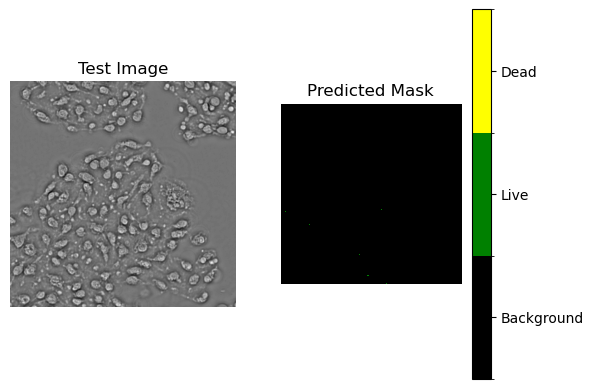

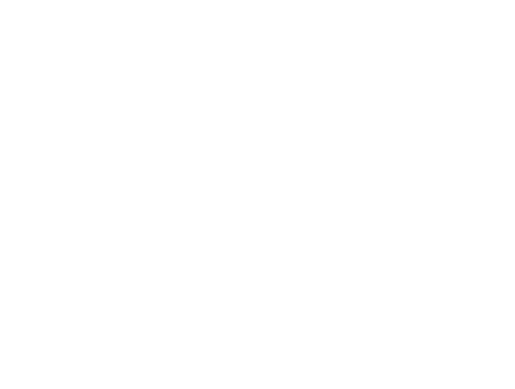

In [ ]:
random_index = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[random_index,:, :, 0]
predicted_mask = preds_test_t[random_index].cpu().numpy()
# predicted_mask_1 = preds_test_t[random_index][0].cpu().numpy()
# predicted_mask_2 = preds_test_t[random_index][1].cpu().numpy()

# predicted_mask = np.zeros_like(predicted_mask_1,dtype=np.uint8)
# predicted_mask[predicted_mask_1>0] = [255,255,0]
# predicted_mask[predicted_mask_2>0] = [128,0,128]

#predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

# print(test_image.shape)
# print(predicted_mask.shape)
#plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(test_image, cmap='gray')
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# plt.imshow(predicted_mask)
# plt.title("Predicted Mask")
show_mask(predicted_mask,"Predicted Mask")
plt.axis('off')

plt.show()


In [22]:
for i in range(len(preds_test_t)):
    predicted_mask = preds_test_t[i].cpu().numpy()
    #predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    mask_name = os.path.join('./new_train/14/test', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('./new_train/14/test', f'image_{i}.jpg')

    plt.savefig(mask_name) 
    plt.close()  

    plt.imshow(X_test[i,:, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(image_name)  
    plt.close() 

In [23]:
# for i in range(4):
#     predicted_mask = preds_test_t[i].cpu().numpy()
#     predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
#     mask1 = predicted_mask[..., 0]  # Assuming the first mask is at index 0
#     mask2 = predicted_mask[..., 1]  # Assuming the second mask is at index 1
#     if mask2.any()>0:
#         print(True)
#     # plt.subplot(i+1, 2, 1)
#     # plt.imshow(mask1,cmap='gray')
#     # plt.subplot(i+1, 2, 2)
#     # plt.imshow(mask2,cmap='gray')

In [24]:
'''
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_train_cpu = x
Y_train_cpu = y

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow_tensor(X_train_cpu[ix])
imshow_tensor(Y_train_cpu[ix])
imshow_tensor(preds_train_t[ix].cpu())
'''


"\nimport random\nimport torch\nimport matplotlib.pyplot as plt\n\n# Define a function to display images\ndef imshow_tensor(tensor):\n    # Ensure the tensor is on the CPU and convert it to a NumPy array\n    #tensor = tensor.cpu().numpy()\n\n    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)\n    if len(tensor.shape) == 3 and tensor.shape[0] == 1:\n        tensor = tensor.squeeze(0)\n\n    # Display the image\n    plt.imshow(tensor, cmap='gray')\n    plt.show()\n\n# Move your tensors to CPU (if they are not already)\nX_train_cpu = x\nY_train_cpu = y\n\n# Perform a sanity check on some random training samples\nix = random.randint(0, len(preds_train_t))\nimshow_tensor(X_train_cpu[ix])\nimshow_tensor(Y_train_cpu[ix])\nimshow_tensor(preds_train_t[ix].cpu())\n"

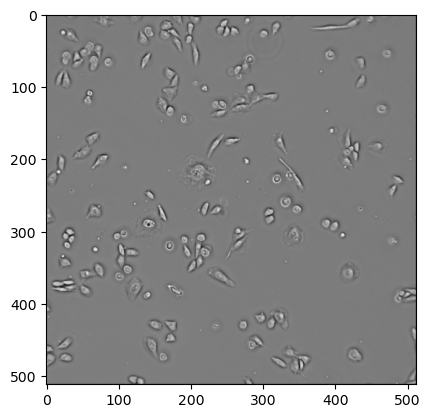

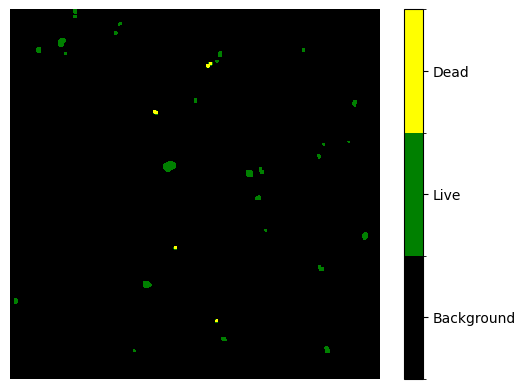

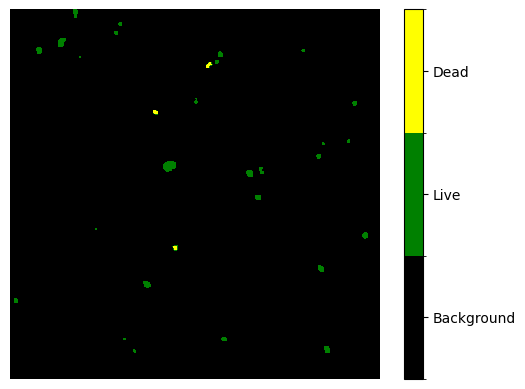

In [25]:
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    if tensor.shape[0] == 3:
        tensor = np.transpose(tensor, (1, 2, 0))

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_val_cpu = x_val
Y_val_cpu = y_val

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t)-1)
predicted_val_mask = preds_val_t[ix].cpu().numpy()
#predicted_val_mask = np.transpose(predicted_val_mask,(1,2,0))

imshow_tensor(X_val_cpu[ix,:,:,0])
#imshow_tensor(Y_val_cpu[ix])
show_mask(Y_val_cpu[ix])
#imshow_tensor(np.squeeze(preds_val[ix]).cpu().astype(np.float32) / 255.0)
show_mask(predicted_val_mask)

In [26]:
import cv2

for i in range(len(preds_val_t)):
    predicted_mask = preds_val_t[i].cpu().numpy()
    #predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
    
    ground_show = Y_val_cpu[i,:,:,0]

    mask_name = os.path.join('./new_train/14/val', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('./new_train/14/val', f'image_{i}.jpg')
    ground_name = os.path.join('./new_train/14/val', f'ground_truth_{i}.jpg')

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    plt.savefig(mask_name)
    plt.close()

    plt.imshow(X_val_cpu[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(image_name)
    plt.close()

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(ground_show, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    plt.savefig(ground_name)
    plt.close()


In [27]:
# # Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# def rle_encoding(x):
#     dots = np.where(x.T.flatten() == 1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b + 1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return run_lengths

# def prob_to_rles(x, cutoff=0.5):
#     lab_img = label(x > cutoff)
#     for i in range(1, lab_img.max() + 1):
#         yield rle_encoding(lab_img == i)
# new_test_ids = []
# rles = []
# for n, id_ in enumerate(test_ids):
#     if n > len(preds_test_t) - 1:
#         n = len(preds_test_t) - 1
#     rle = list(prob_to_rles(preds_test_t[n].cpu()))
#     rles.extend(rle)
#     new_test_ids.extend([id_] * len(rle))
#print(rles)

In [28]:
# import torch.onnx

# dummy_input = torch.randn(1, 3, 128, 128).to(device1)

# model.eval()

# onnx_file_path = "unet_model.onnx"
# torch.onnx.export(model, dummy_input, onnx_file_path, verbose=False)

# print(f"ONNX saved in: {onnx_file_path}")



In [29]:
# image =X.to(device2)
# output = model(image)

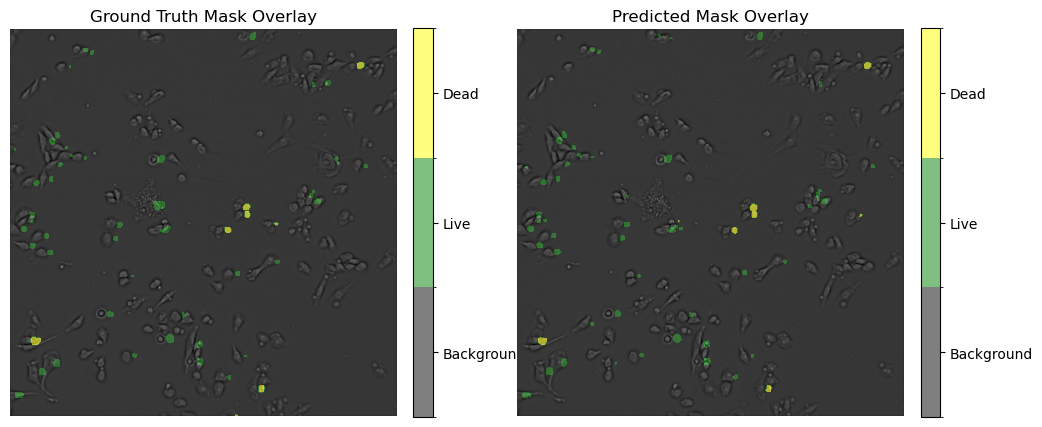

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_masks(image, true_mask, pred_mask):
    from matplotlib.colors import ListedColormap, BoundaryNorm

    # Define the colormap as in your show_mask function
    cmap = ListedColormap(['black', 'green', 'yellow'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12, 6))

    # Plot original image with ground truth mask overlay
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.imshow(true_mask, cmap=cmap, norm=norm, alpha=0.5)
    cbar = plt.colorbar(ticks=[0, 1, 2], fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.title("Ground Truth Mask Overlay")
    plt.axis('off')

    # Plot original image with predicted mask overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(pred_mask, cmap=cmap, norm=norm, alpha=0.5)
    cbar = plt.colorbar(ticks=[0, 1, 2], fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.title("Predicted Mask Overlay")
    plt.axis('off')

    plt.show()

# Example usage:
idx = 2  # Change this index to visualize different images
image = X_val_cpu[idx, :, :, 0]  # Extract original image (grayscale)
true_mask = Y_val_cpu[idx, :, :, 0]  # Extract ground truth mask
pred_mask = preds_val_t[idx].cpu().numpy()  # Predicted mask

# Plot images with both masks overlaid
plot_images_with_masks(image, true_mask, pred_mask)
